In [13]:
# System packages
import os
import sys
import warnings
# Data related
import numpy as np 
import pandas as pd 
import pprint as pp


# sklearn 

# sklearn tools 
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score,  StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.metrics import accuracy_score
import scikitplot.plotters as skplt

# nlp
from gensim.models import KeyedVectors

# models
import xgboost as xgb
import eli5
from eli5.explain import explain_weights
from eli5.formatters import explain_weights_df

In [14]:
warnings.filterwarnings('ignore')

from utils_functions import *

## 1. Load data 

In [10]:
df = pd.read_csv('../data/processed/train_variants_text.csv')
df=df.dropna(subset=['Text'])

### Process data

In [15]:
df['Class'] = df['Class'].astype(int)
df['Gene'] = df['Gene'].astype(str)
df['Variation'] = df['Variation'].astype(str)

y= df['Class']
X= df.drop(['Class','ID'],axis =1)


In [9]:
X.head(1)

,Gene,Variation,Text
0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...


## 3. Model

## 3.1 Bag-of-words 1 Group+xgboost

### Split into Train amd Validation data

In [102]:
X_tr, X_val, y_tr, y_val = split_data(df,
                                      'Text',
                                      'Class',
                                      0.1,
                                      0,
                                      stratify='Class')

In [103]:
clf = Pipeline([('vect', CountVectorizer(preprocessor=clean_text_stemmed, stop_words =stop_words)),
                ('tfidf', TfidfTransformer()),
                ('clf',  xgb.XGBClassifier(objective="multi:softprob", random_state=42))])                           

In [104]:
clf.fit(X_tr, y_tr)  
predicted = clf.predict(X_val)
acc=np.mean(predicted == y_val)
print(acc)

0.6445783132530121


In [111]:
X_te = test.Text.values

In [ ]:
X_te.shape

In [115]:
y_te = clf.predict_proba(X_te)

In [119]:
y_te.shape

(986, 9)

In [121]:
submission_df = pd.DataFrame(y_te, columns=['class'+str(c+1) for c in range(9)])

submission_df['ID'] = df_test['ID']
submission_df.head()

mysubset = ["ID"]
mask = submission_df.columns.isin(mysubset)
submission_df =pd.concat([submission_df.loc[:,mask], submission_df.loc[:,~mask]], axis=1)
submission_df.to_csv('../data/processed/stage2_submission_3.1_new.csv', index=False)

## 3.2 Bag-of-words *3 groups +xgboost

In [23]:
# Select one dataframe column for vectorization
def build_preprocessor(df,field):
    field_idx = list(df.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])
default_preprocessor = CountVectorizer().build_preprocessor()    

In [24]:
vectorizer = FeatureUnion([
    ('Variation',TfidfVectorizer(preprocessor=build_preprocessor(X,'Variation'))),
        ('Gene',TfidfVectorizer(preprocessor=build_preprocessor(X,'Gene'))),
        ('Text',TfidfVectorizer(preprocessor=build_preprocessor(X,'Text'))),
])

In [25]:
X_v = vectorizer.fit_transform(X.values)
X_tr, X_val, y_tr, y_val = train_test_split(X_v,
                                            y,
                                            test_size=0.2,
                                            stratify=y,
                                            random_state=42)

In [27]:
model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
model.fit(X_tr, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [28]:
# Accuracy score 
model.score(X_val,y_val)

0.6385542168674698

In [32]:
df_name = explain_weights_df(model, vec=vectorizer, top=10, feature_filter=lambda x: x != '<BIAS>')
                
df_name.to_csv('../data/features/20190609full_union_3groups_tfidf_feature_weights.csv')

df_name.head(10)

,feature,weight
0,Gene__pten,0.026807
1,Text__57,0.023044
2,Text__unclassified,0.014653
3,Text__1jm7,0.011033
4,Text__expected,0.006895
5,Text__cause,0.006807
6,Text__steric,0.006590
7,Text__treatment,0.006474
8,Text__bioinformatic,0.006417
9,Text__variants,0.006098


In [36]:
# Analyzing individual predictions. Let's check some predictions from the validation set. You see a summary of various vectorizer's contribution at the top, and then below you can see features highlighed in text.
eli5.show_prediction(model, doc=X.values[1], vec=vectorizer)

### Do a kaggle submission 

In [109]:
# Stage 2 test data
df_test = pd.read_csv('../data/processed/stage2_test_variants_text.csv')
df_test.head()

,ID,Gene,Variation,Text
0,1,CHEK2,H371Y,The incidence of breast cancer is increasing i...
1,2,AXIN2,Truncating Mutations,An unselected series of 310 colorectal carcino...
2,3,WNT4,E216G,Mycosis fungoides and Sézary syndrome are prim...
3,4,SUCLA2,G118R,Regulated progression through the cell cycle ...
4,5,BRAF,T599insTT,Pilocytic astrocytoma (PA) is emerging as a tu...


In [110]:
test =df_test.drop(['ID'],axis =1)
test['Gene'] = test['Gene'].astype(str)
test['Variation'] = test['Variation'].astype(str)
test['Text'] = test['Text'].astype(str)
test.head(1)

,Gene,Variation,Text
0,CHEK2,H371Y,The incidence of breast cancer is increasing i...


In [68]:
X_te = vectorizer.transform(test.values)
y_te = model.predict(X_te)
y_te.shape

(986,)

### Prepare submission file

In [81]:
y_pro = model.predict_proba(X_te)
submission_df = pd.DataFrame(y_pro, columns=['class'+str(c+1) for c in range(9)])

submission_df['ID'] = df_test['ID']
submission_df.head()

mysubset = ["ID"]
mask = submission_df.columns.isin(mysubset)
submission_df =pd.concat([submission_df.loc[:,mask], submission_df.loc[:,~mask]], axis=1)
submission_df.to_csv('../data/processed/stage2_submission_3.2.csv', index=False)

,class1,class2,class3,class4,class5,class6,class7,class8,class9,ID
0,0.158321,0.112634,0.020692,0.185344,0.087246,0.090857,0.340086,0.002392,0.002427,1
1,0.856448,0.010093,0.000448,0.026435,0.001082,0.002280,0.102744,0.000204,0.000265,2
2,0.112375,0.235962,0.008642,0.094381,0.096315,0.026855,0.420874,0.002436,0.002161,3
3,0.051843,0.176138,0.002842,0.380138,0.014628,0.015741,0.354217,0.001768,0.002685,4
4,0.013848,0.040591,0.004731,0.074646,0.014663,0.005102,0.844569,0.000898,0.000951,5


## 3.2 Word2vec on Text + xgboost

In [ ]:
X_tr, X_val, y_tr, y_val = split_data(df,
                                      'Text',
                                      'Class',
                                      0.1,
                                      0,
                                      stratify='Class')

In [21]:
# Use document df
w2vec = get_word2vec(
    MySentences(
        df['Text'].values, 
    ),
    'w2vmodel'
)

w2vmodel not found. training model
Model done training. Saving to disk


In [ ]:
clf = Pipeline([('vect', MeanEmbeddingVectorizer(w2vec)),
                ('clf',  xgb.XGBClassifier(objective="multi:softprob", random_state=42))])                           

In [16]:
clf.fit(X_tr, y_tr)  
predicted = clf.predict(X_val)
acc=np.mean(predicted == y_val)
print(acc)

0.6186186186186187


## 3.3 Google News Corpora Word2Vec + xgboost

In [8]:
vector_path = r"/Users/j/Dropbox/Learn/kaggle_quora/src/data/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
gmodel = KeyedVectors.load_word2vec_format (vector_path, binary=True)


W0603 21:10:41.930970 140735731893120 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


In [9]:
clf = Pipeline([('vect', MeanEmbeddingVectorizer(gmodel)),
                ('clf',  xgb.XGBClassifier(objective="multi:softprob", random_state=42))])                           

In [10]:
clf.fit(X_tr, y_tr)  
predicted = clf.predict(X_val)
acc=np.mean(predicted == y_val)
print(acc)

0.5813253012048193


## 3.4 Medical Corpora Word2Vec + xgboost

In [5]:
vector_path = r"../src/pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin"
biomodel = KeyedVectors.load_word2vec_format (vector_path, binary=True)

W0603 20:53:23.172096 140735731893120 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


In [6]:
clf = Pipeline([('vect', MeanEmbeddingVectorizer(biomodel)),
                ('clf',  xgb.XGBClassifier(objective="multi:softprob", random_state=42))])                           

In [7]:
clf.fit(X_tr, y_tr)  
predicted = clf.predict(X_val)
acc=np.mean(predicted == y_val)
print(acc)

0.6024096385542169


/Users/j/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


AxesSubplot(0.125,0.125;0.62x0.755)


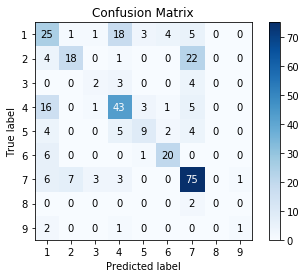

In [15]:
print(skplt.plot_confusion_matrix(y_val, predicted))